```
Admin number : 20A459H    
Name         : Lim Yuan Her
```

## Introduction

The ***breast cancer wisconsin*** dataset, available from the ```SKLearn.datasets``` library (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer), is a binary classification problem containing <u>*569*</u> records consisting of <u>*30*</u> numeric, predictive attributes and the class attribute (Malignant/ Benign).  

We will use this dataset to evaluate the performance of different groups of classifier models as listed below:
1.   **Basic** e.g. Logistic Regression, Naive Bayes
2.   **Ensemble** e.g. Random Forest, AdaBoost
3.   **Voting** (Hard/Soft) using the basic and ensemble models as the base estimators
4.   **Single-Level Stacking** using different combinations of basic classifier models
5.   **Multi-Level Stacking** using the best performing combination of single-level stacking model for the 1<sup>st</sup> level stacking and different combinations of basic classifier models for the 2<sup>nd</sup> level stacking.

We will also demonstrate hyper-parameter tuning of the multi-level stacking model using SKLearn's ```GridSearchCV``` class.

The purpose of this study is to demonstrate the use of **Voting (Hard/Soft)** and **Stacking (Single/Multi)** schemes and demonstrate how use of such schemes can achieve superior performance as compared to basic/ensemble models. 

## 1. Import Libraries

In [ ]:
# importing libraries 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, roc_auc_score, precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.model_selection import train_test_split, ShuffleSplit, learning_curve, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.utils._testing import ignore_warnings 
from sklearn.exceptions import FitFailedWarning, ConvergenceWarning 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from matplotlib.colors import ListedColormap
import time
import warnings

warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 2. Load Data

In [ ]:
# loading breast cancer dataset 
bc_df = load_breast_cancer() 
X = bc_df.data
Y = bc_df.target
print("X:", X.shape, "Y:", Y.shape)

class_labels = bc_df.target_names
print("class_labels:", class_labels)

X: (569, 30) Y: (569,)
class_labels: ['malignant' 'benign']


From the ```class_labels```, we observed that the ***malignant*** class is encoded as <u>**0**</u> and ***benign*** class is encoded as <u>**1**</u> in the dataset. We will recode ***malignant*** class as <u>**1**</u> and ***benign*** class as <u>**0**</u> as the intent is to predict malignant breast cancer cases as the positive class.

In [ ]:
# Recode 'Malignant' to 1 (positive class) and 'Benign' to 0 

# Get "0" and "1" class indices in Y array
where_0 = np.where(Y == 0)
where_1 = np.where(Y == 1)

# Replace "0" with "1" for malignant class and "1" with "0" for benign class
Y[where_0] = 1
Y[where_1] = 0

In [ ]:
# Split data to train/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

## 3. Model Training and Evaluation

### 3.1. Helper functions

We define some helper functions for multiple model training and evaluation metrics collation.

#### 3.1.1. Model Training

In [ ]:
# Performs training for selected models and collates evaluation metrics
def trainModels(models, X_train, y_train, X_test, y_test):

    modelMetrics_dict = []

    for (name, model) in models:
      print()
      print("Classifier:", name)
      print()
      acc, train_time, cm, cr = evalModel(name, model, X_train, y_train, X_test, y_test)
      tn, fp, fn, tp = cm.ravel()
      evalMetrics = {
        'name': name,
        'accuracy': round(acc, 3),
        'training time': round(train_time, 3),
        "true positive": tp,
        "false positive": fp,
        "true negative": tn,
        "false negative": fn,
        'precision_macro': round(cr.loc["macro avg"]["precision"], 3),
        'recall_macro': round(cr.loc["macro avg"]["recall"], 3),
        'f1_macro': round(cr.loc["macro avg"]["f1-score"], 3),
        'precision_0': round(cr.loc["0"]["precision"], 3),
        'precision_1': round(cr.loc["1"]["precision"], 3),
        'recall_0': round(cr.loc["0"]["recall"], 3),
        'recall_1': round(cr.loc["1"]["recall"], 3)  
      }
      modelMetrics_dict.append(evalMetrics)
      print()

    modelMetrics_df = pd.DataFrame.from_dict(modelMetrics_dict)
    modelMetrics_df.sort_values("accuracy", ascending=False, inplace=True)

    return modelMetrics_df

#### 3.1.2. Model Evaluation

In [ ]:
# Plots the precision-recall vs threshold curve
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=12) 
    plt.xlabel("Threshold", fontsize=12)        
    plt.grid(True)
    plt.title("Precision-Recall vs Threshold")
    #plt.show()                                           

# Plots the precision-recall curve
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=12)
    plt.ylabel("Precision", fontsize=12)
    #plt.axis([-5, 10, 0, 1])
    plt.grid(True)
    plt.title("Precision-Recall")
    #plt.show()

# Plots the ROC curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=12) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=12)    
    plt.grid(True)
    plt.title("ROC")
    #plt.show()       

# Plots the learning curve
def plot_learning_curve(label, train_sizes, train_scores, validation_scores):  
    plt.xlabel("Training size")
    plt.ylabel(label)
    plt.ylim(0,0.2)
    plt.plot(train_sizes, train_scores, 'o-', color="r",
             label="Training")
    plt.plot(train_sizes, validation_scores, 'o-', color="g",
             label="Validation")
    plt.legend(loc="best")      
    plt.title("Learning Curve")                              

# Plots the confusion matrix
def plot_confusion_matrix(cm):
    sns.set_context('talk')
    ax = sns.heatmap(cm, annot=True, fmt='d')
    labels = ['NoFall', 'Fall']
    ax.set_xticklabels(labels);
    ax.set_yticklabels(labels);
    ax.set_ylabel('Actual');
    ax.set_xlabel('Predicted');

# Collates evaluation metrics for trained model
def evalModel(name, model, X_train, y_train, X_test, y_test):
    with ignore_warnings(category=[ConvergenceWarning, FitFailedWarning]): 
      start_time = time.time()
      model.fit(X_train, y_train)
      end_time = time.time()
      training_time = end_time - start_time

      y_test_pred = model.predict(X_test)
      test_accuracy = accuracy_score(y_test, y_test_pred )
      test_recall = recall_score(y_test, y_test_pred )

      print('Validation accuracy = {:0.3f}'.format(test_accuracy))
      print('Validation recall = {:0.3f}'.format(test_recall))

      cm = confusion_matrix(y_test, y_test_pred)
      report = classification_report(y_test, y_test_pred, zero_division=0, output_dict=True)
      df_cr = pd.DataFrame(report).transpose()

      if(name != "Hard_Voting"):
        df_preds = pd.DataFrame()
        if hasattr(model, "decision_function"):
          y_test_pred_proba = model.decision_function(X_test)
        else:
          y_test_pred_proba = model.predict_proba(X_test)[:,1]
        df_preds[name] = y_test_pred_proba

        fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
        precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_pred_proba)
      else:
        fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
        precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_pred)       
    
      fig=plt.figure(figsize=(20,4))
      fig.add_subplot(1,3,1)
      plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
      fig.add_subplot(1,3,2)
      plot_precision_vs_recall(precisions, recalls)
      fig.add_subplot(1,3,3)
      plot_roc_curve(fpr, tpr)
      
      plt.show()

      return test_accuracy, training_time, cm, df_cr    

# Highlights best value for each evaluation metric 
def formatSummary(df):
    # Columns used for evaluating maximum
    cols_max =	['accuracy', 'true positive', 'true negative', 'precision_macro', 'recall_macro',
                'f1_macro',	'precision_0',	'precision_1',	'recall_0',	'recall_1']

    # Columns used for evaluating minimum
    cols_min = ['training time', 'false positive', 'false negative'] 

    # Format dataframe for maximum/minimum highlight
    df_display = df.style.highlight_max(subset = cols_max, color = 'yellow').highlight_min(subset = cols_min, color = 'yellow').set_precision(3)
    
    return df_display

### 3.2. Basic Models

We define the group of basic models (```base_estimators```) for training/evaluation 

1.   Logistic Regression
2.   K-Nearest Neigbours
3.   Naives Bayes
4.   Decision Tree

In [ ]:
# Base classifiers 
base_estimators = [] 
base_estimators.append(('LR', LogisticRegression(solver ='liblinear', random_state = 42))) 
base_estimators.append(('KNN', KNeighborsClassifier(n_neighbors=5))) 
base_estimators.append(('GNB', GaussianNB()))
base_estimators.append(('DTC', DecisionTreeClassifier(random_state = 42))) 

We perform model training on basic models (```base_estimators```) and display the evaluation results for comparison


Classifier: LR

Validation accuracy = 0.939
Validation recall = 0.857


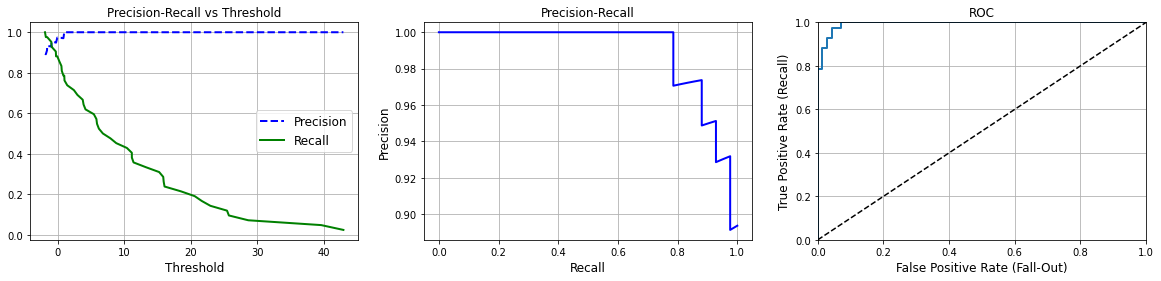



Classifier: KNN

Validation accuracy = 0.912
Validation recall = 0.786


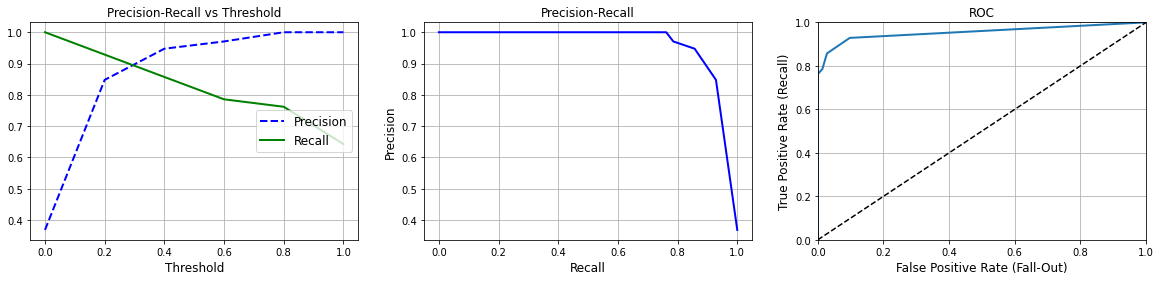



Classifier: GNB

Validation accuracy = 0.939
Validation recall = 0.833


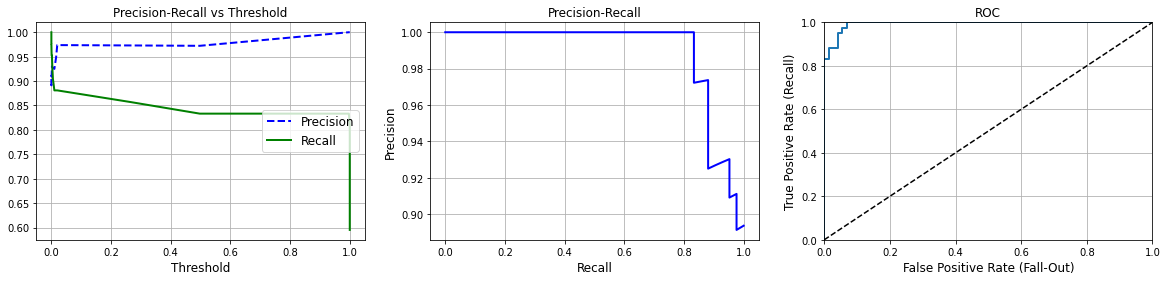



Classifier: DTC

Validation accuracy = 0.930
Validation recall = 0.905


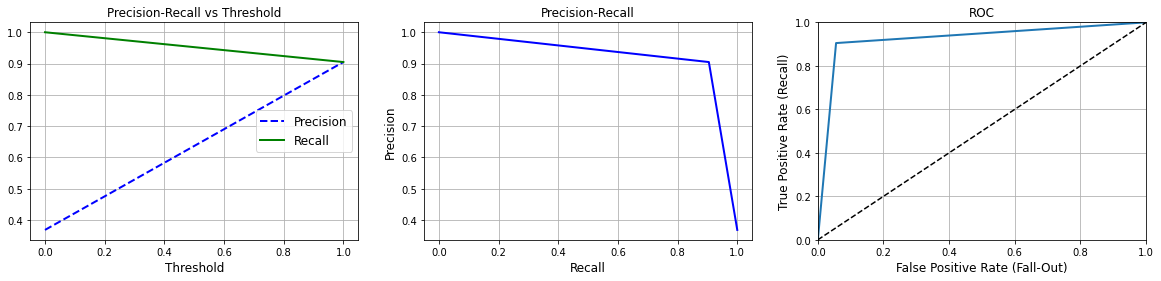

In [ ]:
modelMetrics_basic_df = trainModels(base_estimators, X_train, y_train, X_test, y_test)

In [ ]:
formatSummary(modelMetrics_basic_df)

,name,accuracy,training time,true positive,false positive,true negative,false negative,precision_macro,recall_macro,f1_macro,precision_0,precision_1,recall_0,recall_1
0,LR,0.939,0.009,36,1,71,6,0.948,0.922,0.932,0.922,0.973,0.986,0.857
2,GNB,0.939,0.004,35,0,72,7,0.956,0.917,0.931,0.911,1.000,1.000,0.833
3,DTC,0.930,0.013,38,4,68,4,0.925,0.925,0.925,0.944,0.905,0.944,0.905
1,KNN,0.912,0.002,33,1,71,9,0.929,0.886,0.901,0.888,0.971,0.986,0.786


From the observed results above, **Logistic Regression** and **Naive Bayes** has the best set of evaluation metrics amongst the basic models evaluated

### 3.3. Ensemble Models

We define the group of ensemble models (```ensemble_estimators```) for training/evaluation 

1.   Random Forest
2.   Extra Trees
3.   AdaBoost
4.   Gradient Boosting

In [ ]:
# Ensemble classifiers
ensemble_estimators = [] 
ensemble_estimators.append(('RF', RandomForestClassifier(random_state = 42)))
ensemble_estimators.append(('ET', ExtraTreesClassifier(random_state = 42)))
ensemble_estimators.append(('AB', AdaBoostClassifier(random_state = 42)))
ensemble_estimators.append(('GB', GradientBoostingClassifier(random_state = 42))) 

We perform model training on ensemble models (```ensemble_estimators```) and display the evaluation results for comparison


Classifier: RF

Validation accuracy = 0.974
Validation recall = 0.929


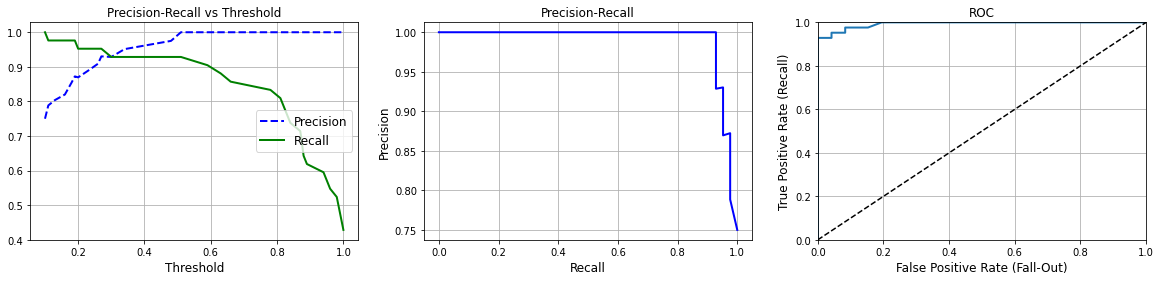



Classifier: ET

Validation accuracy = 0.974
Validation recall = 0.929


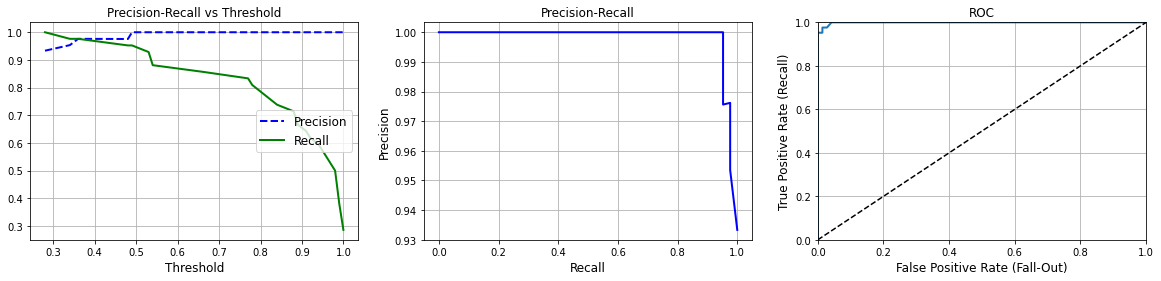



Classifier: AB

Validation accuracy = 0.965
Validation recall = 0.929


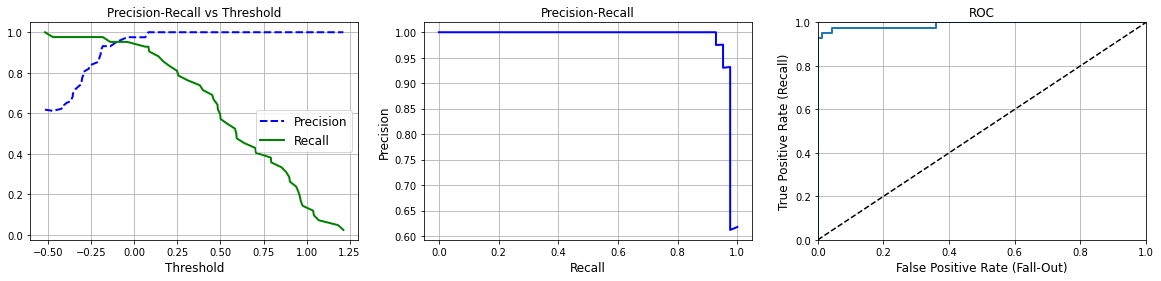



Classifier: GB

Validation accuracy = 0.965
Validation recall = 0.905


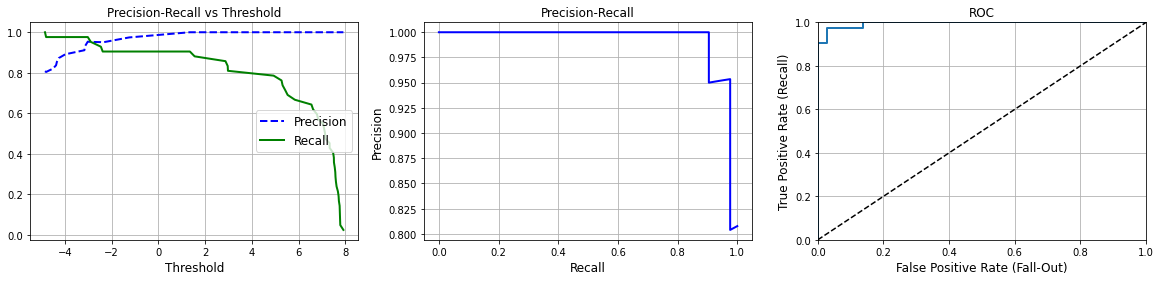

In [ ]:
modelMetrics_ensemble_df = trainModels(ensemble_estimators, X_train, y_train, X_test, y_test)

In [ ]:
formatSummary(modelMetrics_ensemble_df)

,name,accuracy,training time,true positive,false positive,true negative,false negative,precision_macro,recall_macro,f1_macro,precision_0,precision_1,recall_0,recall_1
0,RF,0.974,0.213,39,0,72,3,0.980,0.964,0.971,0.960,1.000,1.000,0.929
1,ET,0.974,0.119,39,0,72,3,0.980,0.964,0.971,0.960,1.000,1.000,0.929
2,AB,0.965,0.156,39,1,71,3,0.967,0.957,0.962,0.959,0.975,0.986,0.929
3,GB,0.965,0.438,38,0,72,4,0.974,0.952,0.961,0.947,1.000,1.000,0.905


From the observed results above, **Random Forest** and **Extra Trees** ensemble models outperformed the basic models but with longer training times.

### 3.4. Voting Models

We define the group of voting models (```voting_estimators```) for training/evaluation 

1.   Hard Voting
2.   Soft Voting

Each group of voting models consists of both basic and ensmeble classifiers.

In [ ]:
# Voting classifiers
voting_estimators = []
voting_models = base_estimators + ensemble_estimators
voting_estimators_hard = VotingClassifier(estimators = voting_models, voting ='hard')
voting_estimators_soft = VotingClassifier(estimators = voting_models, voting ='soft')

voting_estimators.append(('Hard_Voting', voting_estimators_hard))
voting_estimators.append(('Soft_Voting', voting_estimators_soft))

We perform model training on voting models (```voting_estimators```) and display the evaluation results for comparison


Classifier: Hard_Voting

Validation accuracy = 0.974
Validation recall = 0.929


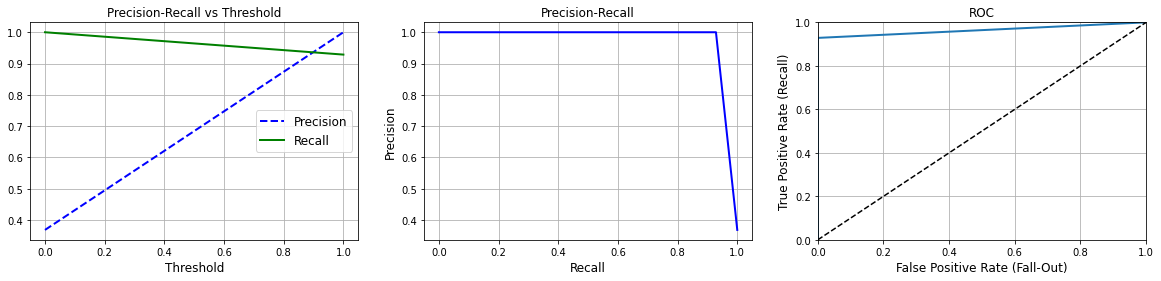



Classifier: Soft_Voting

Validation accuracy = 0.974
Validation recall = 0.929


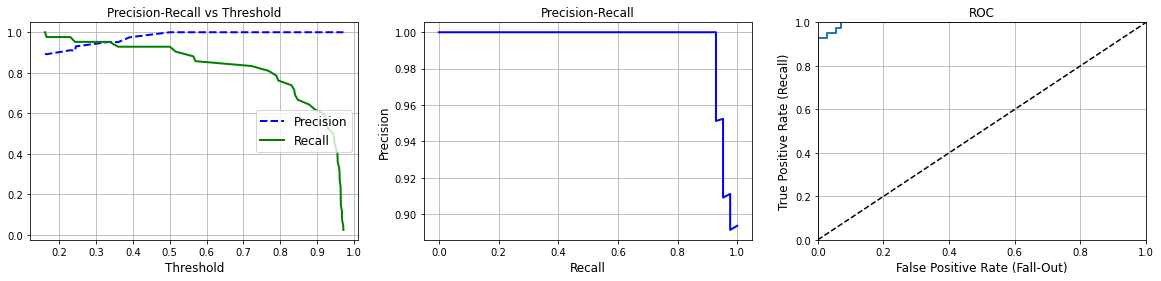

In [ ]:
modelMetrics_voting_df = trainModels(voting_estimators, X_train, y_train, X_test, y_test)

In [ ]:
formatSummary(modelMetrics_voting_df)

,name,accuracy,training time,true positive,false positive,true negative,false negative,precision_macro,recall_macro,f1_macro,precision_0,precision_1,recall_0,recall_1
0,Hard_Voting,0.974,0.920,39,0,72,3,0.980,0.964,0.971,0.960,1.000,1.000,0.929
1,Soft_Voting,0.974,0.922,39,0,72,3,0.980,0.964,0.971,0.960,1.000,1.000,0.929


From the observed results above, voting models are able to achieve comparable performance to that of individual basic and ensemble models, but at the expense of much longer training times.



### 3.5. Stacking Models

#### 3.5.1. Single-Level

We define the group of single level stacking models (```single_stacking_estimators```) for training/evaluation 



In [ ]:
# Single-Level Stacking classifiers
single_stacking_estimators = []
stacking_models = base_estimators + ensemble_estimators
meta_classifier = LogisticRegression(solver ='liblinear', random_state=42)
SingleLevelStackingClassifier = StackingClassifier(estimators=stacking_models, final_estimator=meta_classifier)
single_stacking_estimators.append(('Single Level Stacking', SingleLevelStackingClassifier))

We perform model training on single level  stacking models (```single_stack_estimators```) and display the evaluation results for comparison


Classifier: Single Level Stacking

Validation accuracy = 0.974
Validation recall = 0.929


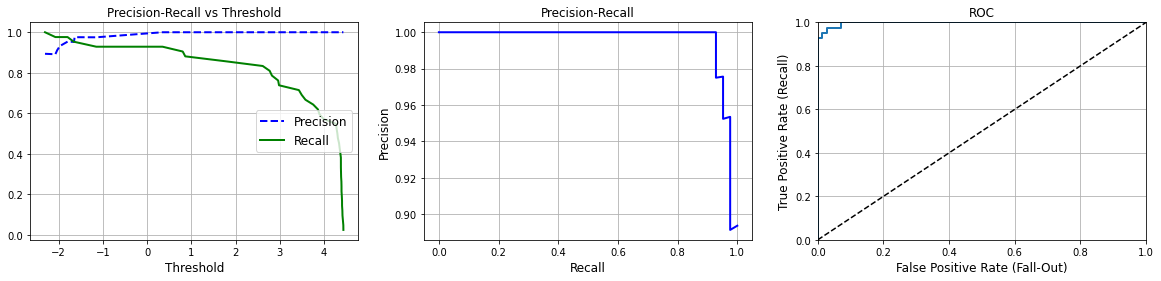

In [ ]:
modelMetrics_single_stacking_df = trainModels(single_stacking_estimators, X_train, y_train, X_test, y_test)

In [ ]:
modelMetrics_single_stacking_df

,name,accuracy,training time,true positive,false positive,true negative,false negative,precision_macro,recall_macro,f1_macro,precision_0,precision_1,recall_0,recall_1
0,Single Level Stacking,0.974,4.938,39,0,72,3,0.98,0.964,0.971,0.96,1.0,1.0,0.929


From the observed results above, **Single Level Stacking** model can match the performance of voting models but at the expense of much longer times.

##### 3.5.1.1. Stacking Combinations

We generate a list of n-model combinations e.g. (Logistic Regression, Decision Tree), (Naive Bayes, Linear SVC, Decision Tree) etc. as base estimators for separate single level stacking estimators to find the combination achieving the best performance but at much shorter training times.

In [ ]:
# Classifier labels list from stacking_models (basic and ensemble models)
clf_labels = [estimator[0] for estimator in stacking_models]

# Get all unique combinations of classifier with a set size greater than or equal to 2
combo_clfs = []
for i in range(2, len(clf_labels)+1):
    for subset in itertools.combinations(clf_labels, i):
        combo_clfs.append(subset)

In [ ]:
# Stack, tune, and evaluate stack of classifiers

modelMetrics_combo_singlestack_df = pd.DataFrame()
meta_learners = [("LR", meta_classifier)]

for combo in combo_clfs:
    # Get labels of classifier to create a stack
    labels = list(combo)
     
    # Get classifiers for the stacking model base estimators
    base_combo_estimator = []
    for i in range(len(labels)):
        est = dict(stacking_models)[labels[i]]
        base_combo_estimator.append((labels[i], est))

    # Loop through all base_estimators as meta-classifier for the stacking model with 
    # the base estimators as defined above
    for j in range(len(meta_learners)):
        meta_learner = meta_learners[j][1]
        stacking_clf = StackingClassifier(estimators=base_combo_estimator, final_estimator=meta_learner)
        all_estimator = [(",".join(labels) + ": " + meta_learners[j][0], stacking_clf)] 

        modelMetrics_df = trainModels(all_estimator, X_train, y_train, X_test, y_test)
        modelMetrics_combo_singlestack_df = modelMetrics_combo_singlestack_df.append(modelMetrics_df, ignore_index=True)

In [ ]:
formatSummary(modelMetrics_combo_singlestack_df.sort_values(by=['accuracy'], ascending=False)[:5])

,name,accuracy,training time,true positive,false positive,true negative,false negative,precision_macro,recall_macro,f1_macro,precision_0,precision_1,recall_0,recall_1
25,"ET,AB: LR",0.982,1.544,40,0,72,2,0.986,0.976,0.981,0.973,1.000,1.000,0.952
177,"LR,GNB,DTC,ET,AB: LR",0.974,1.634,39,0,72,3,0.980,0.964,0.971,0.960,1.000,1.000,0.929
89,"LR,KNN,DTC,RF: LR",0.974,1.226,39,0,72,3,0.980,0.964,0.971,0.960,1.000,1.000,0.929
166,"LR,KNN,DTC,RF,GB: LR",0.974,3.373,39,0,72,3,0.980,0.964,0.971,0.960,1.000,1.000,0.929
167,"LR,KNN,DTC,ET,AB: LR",0.974,1.640,39,0,72,3,0.980,0.964,0.971,0.960,1.000,1.000,0.929


From the observed results above, a single-level stacking model with base estimator combination of **Extra Trees/ AdaBoost** and **Logistic Regression** as the meta-learner managed to outperform basic/ ensemble/ voting models by with longer training times.

![Single-level Stacking Model](https://i.ibb.co/Y04JL3M/Single-Stack.png)

#### 3.5.2. Multi-Level

We define a group of multi level stacking models (```multi_stacking_estimators```) for training/evaluation 

In [ ]:
# Multi-Level Stacking classifiers

L1_estimators = [] 
L1_estimators.append(('ET', ExtraTreesClassifier(random_state = 42)))
L1_estimators.append(('AB', AdaBoostClassifier(random_state = 42)))

L2_estimators = [] 
L2_estimators.append(('LinearSVC', SVC(kernel='linear', probability=True, random_state = 42)))
L2_estimators.append(('DTC', DecisionTreeClassifier(random_state = 42)))

L2_stacking_classifier = StackingClassifier(estimators=L2_estimators, final_estimator=meta_classifier)
L1_stacking_classifier = StackingClassifier(estimators=L1_estimators, final_estimator=L2_stacking_classifier)

multi_stacking_estimators = []
multi_stacking_estimators.append(('Multi Level Stacking', L1_stacking_classifier))

We perform model training on multi level  stacking models (```multi_stack_estimators```) and display the evaluation results for comparison


Classifier: Multi Level Stacking

Validation accuracy = 0.982
Validation recall = 0.952


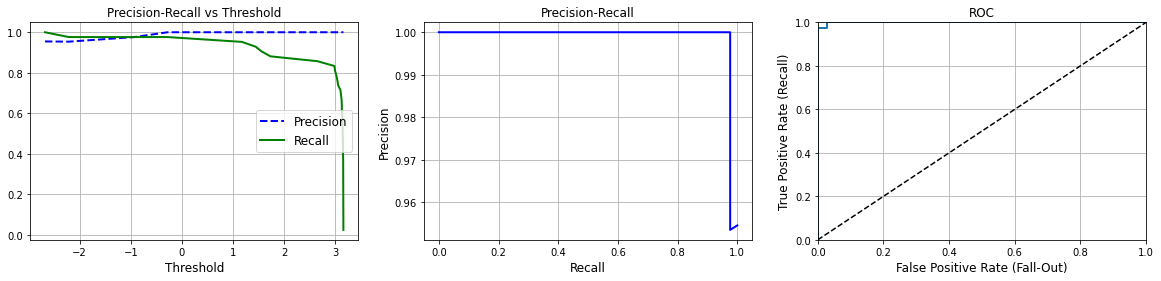

In [ ]:
modelMetrics_multi_stacking_df = trainModels(multi_stacking_estimators, X_train, y_train, X_test, y_test)

In [ ]:
modelMetrics_multi_stacking_df.sort_values('accuracy')

,name,accuracy,training time,true positive,false positive,true negative,false negative,precision_macro,recall_macro,f1_macro,precision_0,precision_1,recall_0,recall_1
0,Multi Level Stacking,0.982,1.57,40,0,72,2,0.986,0.976,0.981,0.973,1.0,1.0,0.952


From the observed results above, **Multi Level Stacking** model can match the performance of **Single Level Stacking** model but requires appropriate selection of the level 2 base classifiers in order to outperform, which will be studied in the next section.

##### 3.5.2.1. Stacking Combinations

Based on the single-level stacking model evaluation results above (see section 3.5.1.1), the **Extra Trees/ AdaBoost** combination as base estimators will provide the best performance.

In order to improve the performance, we try a 2-level multi-stacking model using **Extra Trees/ AdaBoost** as base estimators for the 1<sup>st</sup> level stacking combination. 

As for the 2<sup>nd</sup> level stacking combination, we generate a list of n-model combinations e.g. (Logistic Regression, Decision Tree), (Naive Bayes, Linear SVC, Decision Tree) etc. as base estimators to find the 2<sup>nd</sup> level stacking combination that, together with the 1<sup>st</sup>  level stacking combination, will outperform the single-level stacking model with comparable training times.

In [ ]:
# Stack, tune, and evaluate stack of classifiers

modelMetrics_combo_multistack_df = pd.DataFrame()
meta_learners = [("LR", meta_classifier)]

L1_labels = ','.join([i[0] for i in L1_estimators])

for combo in combo_clfs:
    # Get labels of classifier to create a stack
    labels = list(combo)
     
    # Get classifiers
    L2_estimators = []
    for i in range(len(labels)):
        est = dict(stacking_models)[labels[i]]
        L2_estimators.append((labels[i], est))

    # Stacking Classifier
    for j in range(len(base_estimators)):
        meta_learner = base_estimators[j][1]

        L2_stacking_classifier = StackingClassifier(estimators=L2_estimators, final_estimator=meta_learner)
        L1_stacking_classifier = StackingClassifier(estimators=L1_estimators, final_estimator=L2_stacking_classifier)

        all_estimator = [(L1_labels + ": " + ",".join(labels) + ": " + base_estimators[j][0], L1_stacking_classifier)] 

        modelMetrics_df = trainModels(all_estimator, X_train, y_train, X_test, y_test)
        modelMetrics_combo_multistack_df = modelMetrics_combo_multistack_df.append(modelMetrics_df, ignore_index=True)

In [ ]:
accuracy_max = modelMetrics_combo_multistack_df.accuracy == modelMetrics_combo_multistack_df.accuracy.max()

formatSummary(modelMetrics_combo_multistack_df[accuracy_max].sort_values(by=['training time'])[:5])


,name,accuracy,training time,true positive,false positive,true negative,false negative,precision_macro,recall_macro,f1_macro,precision_0,precision_1,recall_0,recall_1
8,"ET,AB: LR,DTC: LR",0.991,1.560,41,0,72,1,0.993,0.988,0.991,0.986,1.000,1.000,0.976
118,"ET,AB: LR,KNN,DTC: GNB",0.991,1.671,41,0,72,1,0.993,0.988,0.991,0.986,1.000,1.000,0.976
10,"ET,AB: LR,DTC: GNB",0.991,1.684,41,0,72,1,0.993,0.988,0.991,0.986,1.000,1.000,0.976
34,"ET,AB: KNN,DTC: GNB",0.991,1.700,41,0,72,1,0.993,0.988,0.991,0.986,1.000,1.000,0.976
230,"ET,AB: KNN,DTC,GB: GNB",0.991,1.955,41,0,72,1,0.993,0.988,0.991,0.986,1.000,1.000,0.976


From the observed results above, 2<sup>nd</sup> level estimator combination of **Logistic Regression/ Decision Tree** achieved the best performance amongst the combinations evaluated.

![Multilevel Stacking Model](https://i.ibb.co/hL2rxz7/Multi-Stack-Model.jpg)

#### 3.5.3. Comparison

In [ ]:
# Get best performing models from basic, ensemble, voting, single-level stacking and multi-level stacking models.
basic = modelMetrics_basic_df[modelMetrics_basic_df.name == "LR"]
ensemble = modelMetrics_ensemble_df[modelMetrics_ensemble_df.name == "ET"]
voting = modelMetrics_voting_df[modelMetrics_voting_df.name == "Soft_Voting"]
combo_singleStack = modelMetrics_combo_singlestack_df[modelMetrics_combo_singlestack_df.name == "ET,AB: LR"]
combo_multiStack = modelMetrics_combo_multistack_df[modelMetrics_combo_multistack_df.name == "ET,AB: LR,DTC: LR"]

summary_compare = pd.concat([basic, ensemble, voting, combo_singleStack, combo_multiStack], axis=0, ignore_index=True)
formatSummary(summary_compare.sort_values(by=['accuracy'], ascending=False))

,name,accuracy,training time,true positive,false positive,true negative,false negative,precision_macro,recall_macro,f1_macro,precision_0,precision_1,recall_0,recall_1
4,"ET,AB: LR,DTC: LR",0.991,1.560,41,0,72,1,0.993,0.988,0.991,0.986,1.000,1.000,0.976
3,"ET,AB: LR",0.982,1.544,40,0,72,2,0.986,0.976,0.981,0.973,1.000,1.000,0.952
1,ET,0.974,0.119,39,0,72,3,0.980,0.964,0.971,0.960,1.000,1.000,0.929
2,Soft_Voting,0.974,0.922,39,0,72,3,0.980,0.964,0.971,0.960,1.000,1.000,0.929
0,LR,0.939,0.009,36,1,71,6,0.948,0.922,0.932,0.922,0.973,0.986,0.857


From the summarized results above, using a **multi-level stacking** model with 1<sup>st</sup> stacking level classifiers **Extra Trees/ AdaBoost** and 2<sup>nd</sup> stacking level classifiers **Logistic Regression/ Decision Tree** with **Logistic Regression** as the meta-learner  can produce the best performance at the cost of longer training times.

## 4. Hyper-parameter Tuning

We perform hyperparameter tuning on the multi-level stacking model based on the optimal combination of base estimators as evaluated above.

1.   Level 1 Classifiers - Extra Trees/ AdaBoost
2.   Level 2 Classfiers - Logistic Regression, Decision Tree
3.   Meta-Classifier - Logistic Regression


In [ ]:
# First level classifiers (Extra Trees/ AdaBoost)
L1_estimators = [] 
L1_estimators.append(('ET', ExtraTreesClassifier(random_state = 42)))
L1_estimators.append(('AB', AdaBoostClassifier(random_state = 42)))

# Second level classifiers (Logistic Regression/ Decision Tree)
L2_estimators = [] 
L2_estimators.append(('LR', LogisticRegression(solver ='liblinear', random_state = 42))) 
L2_estimators.append(('DTC', DecisionTreeClassifier(random_state = 42)))

# Meta Classifier ( Logistic Regression)
meta_classifier = LogisticRegression(solver ='liblinear', random_state = 42)

# Multi-level stacking classifier based on L1_estimators, L2 estimators and meta-classifier
L2_stacking_classifier = StackingClassifier(estimators=L2_estimators, final_estimator=meta_classifier)
L1_stacking_classifier = StackingClassifier(estimators=L1_estimators, final_estimator=L2_stacking_classifier)

stacked_optimum_combo_estimator = L1_stacking_classifier

We perform hyperparameter tuning on the ```stack_method``` parameter to determine the optimal setting that produces the best performance.

In [ ]:
# Define parameter grid 
params = {"stack_method": ['auto', 'predict_proba', 'decision_function', 'predict']}

# Initialize GridSearchCV
grid = GridSearchCV(estimator = stacked_optimum_combo_estimator, 
                    param_grid = params, 
                    cv = 5,
                    scoring = "accuracy",
                    verbose = 0,
                    n_jobs = -1)

# Fit GridSearchCV
grid.fit(X_train, y_train)

# Making prediction on test set
y_pred = grid.predict(X_test)

# Getting accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print results
print(f"The Accuracy of the tuned Stacking classifier is {accuracy:.3f}")
print(grid.best_params_)

The Accuracy of the tuned Stacking classifier is 0.991
{'stack_method': 'auto'}


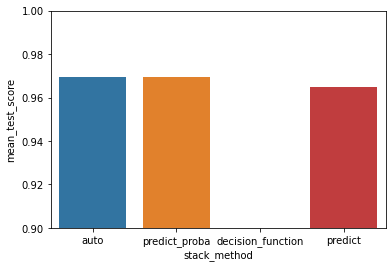

In [ ]:
# Helper function for plotting GridSearchCV results
def plotGridSearchResults(search_results, param_x, param_y):
  cv_results = pd.DataFrame(search_results)
  col_x = 'param_' + param_x
  sns.barplot(x=col_x, y=param_y, data=cv_results, ci=99, n_boot=64)
  plt.xlabel(param_x)
  plt.ylabel(param_y)
  plt.ylim(0.9, 1.0)

# Plot GridSearchCV results (mean_test_score) for stack_method hyperparameter
plotGridSearchResults(grid.cv_results_, "stack_method", "mean_test_score")

From the observed results above, setting ***auto*** for the ```stack_method``` parameter of the ```StackingClassifier``` class produces the most optimal model.